In [50]:
from tensorflow import keras
from keras.layers import RNN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [61]:
data= pd.read_csv('Walmart.csv', index_col='Date')
week1 = data[data['Store']==1]['Weekly_Sales']
week = week1.values

Date
05-02-2010    1643690.90
12-02-2010    1641957.44
19-02-2010    1611968.17
26-02-2010    1409727.59
05-03-2010    1554806.68
                 ...    
28-09-2012    1437059.26
05-10-2012    1670785.97
12-10-2012    1573072.81
19-10-2012    1508068.77
26-10-2012    1493659.74
Name: Weekly_Sales, Length: 143, dtype: float64

In [52]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(week.reshape(-1, 1))

In [53]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [54]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

95 48


In [55]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [56]:
from keras import Sequential
from keras.layers import Dense, LSTM

In [57]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
93/93 - 4s - loss: 0.0472 - 4s/epoch - 41ms/step
Epoch 2/100
93/93 - 0s - loss: 0.0255 - 433ms/epoch - 5ms/step
Epoch 3/100
93/93 - 1s - loss: 0.0199 - 519ms/epoch - 6ms/step
Epoch 4/100
93/93 - 1s - loss: 0.0187 - 543ms/epoch - 6ms/step
Epoch 5/100
93/93 - 1s - loss: 0.0184 - 608ms/epoch - 7ms/step
Epoch 6/100
93/93 - 1s - loss: 0.0183 - 539ms/epoch - 6ms/step
Epoch 7/100
93/93 - 0s - loss: 0.0182 - 392ms/epoch - 4ms/step
Epoch 8/100
93/93 - 0s - loss: 0.0181 - 364ms/epoch - 4ms/step
Epoch 9/100
93/93 - 0s - loss: 0.0180 - 367ms/epoch - 4ms/step
Epoch 10/100
93/93 - 1s - loss: 0.0180 - 548ms/epoch - 6ms/step
Epoch 11/100
93/93 - 0s - loss: 0.0180 - 309ms/epoch - 3ms/step
Epoch 12/100
93/93 - 0s - loss: 0.0178 - 329ms/epoch - 4ms/step
Epoch 13/100
93/93 - 0s - loss: 0.0178 - 332ms/epoch - 4ms/step
Epoch 14/100
93/93 - 0s - loss: 0.0177 - 420ms/epoch - 5ms/step
Epoch 15/100
93/93 - 1s - loss: 0.0176 - 587ms/epoch - 6ms/step
Epoch 16/100
93/93 - 0s - loss: 0.0176 - 464ms/epoc

In [58]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 9ms/step
Train Score: 135680.98 RMSE
Test Score: 166862.30 RMSE


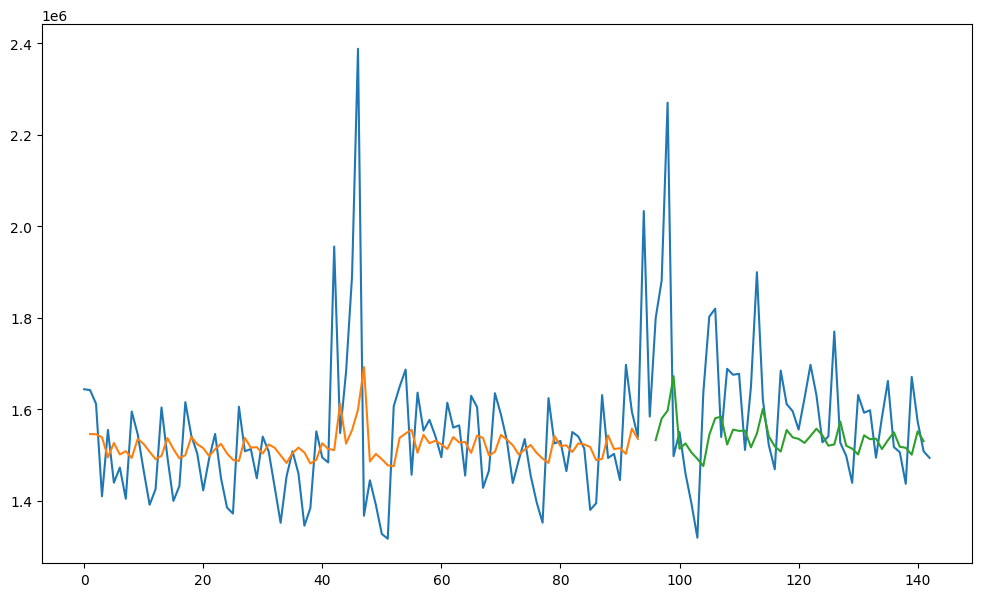

In [60]:
import matplotlib.pyplot as plt
# shift train predictions for 
plt.figure(figsize=(12, 7))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
